# Effective complexity
Tutorial code running a synthetic dataset with an mlp predictor

In [8]:
import matplotlib.pyplot as plt
import numpy as np
#from effective_complexity.model import MLP, initialize_weights
import torch.nn as nn
import torch
from tqdm import tqdm
import torch.optim as optim
import os
from datetime import datetime

from torch.utils.data import DataLoader
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms, utils
import torch
import numpy as np
from tqdm import tqdm
import math

import torch
import torch.nn as nn
from effective_complexity.models.models import DistributionComponents
import torch.nn.functional as F

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import math

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



Model selection

In [9]:
def model_mlp(hyperparams):
    class MLP(nn.Module, DistributionComponents):
        def __init__(self, input_size, hidden_sizes, embedding_size=3,output_size=3, flatten_input=False):
            super(MLP, self).__init__()
            # Define layers
            self.flatten = flatten_input
            self.layers = nn.ModuleList()
            in_features = input_size
            for hidden_size in hidden_sizes:
                self.layers.append(nn.Linear(in_features, hidden_size))
                in_features = hidden_size
            self.fx = nn.Linear(in_features, embedding_size)
            self.W = nn.Linear(embedding_size, output_size)

        def forward(self, x):
            if self.flatten:
                x = x.reshape(x.shape[0], 32 * 32 * 3)
            
            # Pass input through each layer with ReLU activation
            for layer in self.layers:
                x = F.relu(layer(x))
            # Output layer
            x = self.fx(x)
            return x
        
        def get_fx(self, x):
            return x
        
        #Probably needs to change
        def get_unembeddings(self, y):
            return torch.matmul(self.W.weight.t(),y)
        
        def get_W(self):
            return self.W.weight

    flatten_input = hyperparams['flatten_input']
    input_size = hyperparams['input_size']
    hidden_sizes = hyperparams['hidden_sizes']
    embedding_size = hyperparams['embedding_size']
    num_classes = hyperparams['num_classes']
    model = MLP(input_size, hidden_sizes,embedding_size, num_classes, flatten_input)
    return model

Hyperparams

In [10]:
hyperparams = {
    "DIMS": 3,
    "COV": 1,
    "MU" : 0,
    "input_size" : 3,
    "hidden_sizes" : [64,32,64],
    "num_samples" : 1000,
    "BATCH_SIZE" : 256,
    "flatten_input" : False,
    "num_classes" : 3,
}

Data generation

In [11]:
eps = 10e-4

def collate_fn(batch):
    """ Custom function to collate dictionary-based data. """
    inputs = torch.stack([item["x"] for item in batch])  # Stack 3D tensors
    labels = torch.stack([item["label"] for item in batch])  # Convert labels to tensor
    return {"x": inputs, "label": labels}


def dataset_synthetic(hyperparams):
    class SYNTHETIC(Dataset):

        def __init__(self):
            """
            Custom PyTorch Dataset that stores an array of dictionaries.

            Args:
                data (list of dicts): Each dictionary represents a data point with keys as feature names.
            """
            self.data = []

        def __len__(self):
            """Returns the number of samples in the dataset."""
            return len(self.data)

        def __getitem__(self, idx):
            """
            Retrieves a single sample from the dataset.

            Args:
                idx (int): Index of the sample.

            Returns:
                dict: A dictionary containing the features of the indexed sample.
            """
            return self.data[idx]
        
        def add_item(self, item):
            """
            Adds a new item (dictionary) to the dataset.

            Args:
                item (dict): A dictionary containing the new data sample.
            """
            if not isinstance(item, dict):
                raise ValueError("Item must be a dictionary.")
            self.data.append(item)
        
        def add_items(self, items):
            """
            Adds tensor as dataset.

            Args:
                items (dict): A dict containing data samples as tensors.
            """

            if not isinstance(items, dict):
                raise ValueError("Item must be a dict.")
            self.data= [dict(zip(items.keys(), values)) for values in zip(*items.values())]
        
    train_percent=0.7
    test_percent = 0.2
    val_percent = 0.1

    # Number of points to sample
    num_samples = hyperparams['num_samples']
    DIMS = hyperparams['DIMS']
    COV = hyperparams['COV']
    MU = hyperparams['MU']
    BATCH_SIZE = hyperparams['BATCH_SIZE']
    num_classes = hyperparams['num_classes']
    
    
    one_hots = torch.eye(num_classes).float()

    train_dataset = SYNTHETIC()
    test_dataset = SYNTHETIC()
    val_dataset = SYNTHETIC()

    with torch.no_grad():
        # Create a random tensor of 3 dimensions with Gaussian distribution
        if not isinstance(DIMS, int):
            random_tensors = []
            for _ in range(num_samples):
                tensor = torch.randn(DIMS)
                random_tensors.append(tensor)
            samples = torch.stack(random_tensors)
        else:
            #Generate data and W
            mu_sample = np.full(DIMS,MU)
            covariance_sample = np.diag(np.full(DIMS,COV))

            # Sample points
            samples = np.random.multivariate_normal(mu_sample, covariance_sample, num_samples)
            samples = torch.from_numpy(samples).float()
        #Define orthogonal vectors
        w1 = torch.tensor([1,1,1])
        w2 = torch.tensor([1,-1,0])
        w3 = torch.tensor([1,1,-2])
        W = torch.stack([w1,w2,w3], dim = 0).t().float()


        #generate f_x
        # Instantiate the MLP (f(x))
        hyperparams['embedding_size'] = 3
        mlp_model = model_mlp(hyperparams)
        #mlp_model.apply(initialize_weights)
        


        embedding_outputs = mlp_model(samples)
        f_x = mlp_model.get_fx(embedding_outputs)
        unembedding = torch.matmul(W, one_hots)
        logits = torch.matmul(f_x, unembedding)

        # Define the softmax layer
        softmax = torch.nn.Softmax(dim=-1)
        distrib = softmax(logits)

        sum = torch.sum(distrib, dim=1)
        assert torch.all(sum > 1 - eps) and torch.all(sum < 1 + eps)

        #Shuffle sample tensor
        #torch.randperm?

        #Add to the dataset
        train_end_index = math.floor(num_samples*train_percent)
        train_dataset.add_items({'x':samples[:train_end_index, :] , 'label':distrib[:train_end_index, :]})
        val_start_index = train_end_index
        val_end_index = math.floor(num_samples*(train_percent+val_percent))
        val_dataset.add_items({'x':samples[val_start_index:val_end_index, :], 'label': distrib[val_start_index:val_end_index, :]})
        test_start_index = val_end_index
        test_dataset.add_items({'x': samples[test_start_index:, :], 'label':distrib[test_start_index:, :]})


    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader

Train functions

In [12]:

eps = 1e-6
l1_lambda = 1e-4
l2_lambda = 1e-4
l1_weight = 0
l2_weight = 0

def elastic_net_regularization(model, l1_lambda, l2_lambda, l1_weight, l2_weight):
    l1_penalty = sum(p.abs().sum() for p in model.parameters())  # L1 norm
    l2_penalty = sum((p ** 2).sum() for p in model.parameters())  # L2 norm
    return l1_weight * l1_lambda * l1_penalty + l2_weight * l2_lambda * l2_penalty


def train_loop(train_loader, model, criterion, optimizer, device = 'cpu'):
    model.train()
    logsoftmax = nn.LogSoftmax(dim=-1)
    total_loss = 0
    accuracy = 0
    total = 0
    correct = 0

    d = model.get_W().shape[0]
    one_hots = torch.eye(d).float()


    for batch in train_loader:
        optimizer.zero_grad()
        labels = batch['label'].to(device)
        inputs = batch['x'].to(device)
        embedding_output = model(inputs)
        #Compute f_x from output
        f_x = model.get_fx(embedding_output)
        #Compute unenmbed from output
        unembedding = model.get_unembeddings(one_hots)
        logits = torch.matmul(f_x, unembedding)



        outputs = logsoftmax(logits)
        #MINIMIZE KL DIVERGENCE
        loss = criterion(outputs, labels)
        loss += elastic_net_regularization(model, l1_lambda, l2_lambda, l1_weight, l2_weight)

        total_loss += loss.item()
        #Accuracy computation
        #_, predicted = torch.max(outputs, 1)
        #correct += (predicted == labels).sum().item()
        #total += labels.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    #accuracy = correct / total
    return avg_loss, accuracy



def val_loop(val_loader, model, criterion, device = 'cpu'):
    model.eval()  # Set model to evaluation mode (no gradient computation)
    total_loss = 0.0
    accuracy = 0
    total = 0
    correct = 0
    logsoftmax = nn.LogSoftmax(dim=-1)
    d = model.get_W().shape[0]
    one_hots = torch.eye(d).float()



    with torch.no_grad():  # No need to track gradients
        for batch in val_loader:
            inputs = batch['x'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)

            #Compute f_x from output
            f_x = model.get_fx(outputs)
            #Compute unenmbed from output
            unembedding = model.get_unembeddings(one_hots)

            logits = torch.matmul(f_x, unembedding)

            outputs = logsoftmax(logits)
            #outputs = logsoftmax(logits)
            loss = criterion(outputs, labels)
            loss += elastic_net_regularization(model, l1_lambda, l2_lambda, l1_weight, l2_weight)


            total_loss += loss.item()
            #Accuracy computation
            #_, predicted = torch.max(outputs, 1)
            #correct += (predicted == labels).sum().item()
            #total += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    #accuracy = correct / total
    return avg_loss, accuracy


def test_loop(test_loader, model, criterion, device='cpu'):
    model.eval()  # Set model to evaluation mode (no gradient computation)
    total_loss = 0.0
    accuracy = 0
    total = 0
    correct = 0
    logsoftmax = nn.LogSoftmax(dim=-1)
    softmax = nn.Softmax(dim=-1)

    total_fx = []

    d = model.get_W().shape[0]
    one_hots = torch.eye(d).float()


    with torch.no_grad():  # No need to track gradients
        for batch in test_loader:
            inputs = batch['x'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)

            #Compute f_x from output
            f_x = model.get_fx(outputs)
            total_fx.append(f_x)
            #Compute unembeddings
            unembedding = model.get_unembeddings(one_hots)

            logits = torch.matmul(f_x, unembedding)

            outputs = logsoftmax(logits)
            outputs_to_return = softmax(logits)

            loss = criterion(outputs, labels)
            loss += elastic_net_regularization(model, l1_lambda, l2_lambda, l1_weight, l2_weight)


            total_loss += loss.item()
            #Accuracy computation
            #_, predicted = torch.max(outputs, 1)
            #correct += (predicted == labels).sum().item()
            #total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    #accuracy = correct / total
    return avg_loss, accuracy, total_fx, outputs_to_return
            

Functions to apply on data

In [13]:
def apply_pca(data, num_components=2):
    # Apply PCA to reduce to 2 dimensions
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(data)
    data_reconstructed = pca.inverse_transform(pca_result)
    return pca_result, data_reconstructed

def apply_tsne(data, num_components=2, perplexity=30, random_state=42):
    # Apply t-SNE to reduce to 2 dimensions for visualization
    tsne = TSNE(n_components=num_components, perplexity=perplexity, random_state=random_state)
    tsne_result = tsne.fit_transform(data)
    return tsne_result

def show_distrib(distrib, method = 'NOT', predicted = True, show = False):

    dim = distrib.shape[1]
    if predicted:
        exp = 'predicted'
    else:
        exp = 'reference'
    # Plotting 2D data
    if dim == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(distrib[:, 0], distrib[:, 1], c='blue', alpha=0.6)
        plt.title(f"{method.upper()} Reduced Visualization of {exp} Data (2D)") 
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
    
    # Plotting 3D data
    elif dim == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(distrib[:, 0], distrib[:, 1], distrib[:, 2], c='blue', alpha=0.6)
        ax.set_title(f"{method.upper()} Reduced Visualization of {exp} Data (3D)")
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        ax.set_zlabel("Dimension 3")
    else:
        raise ValueError("target_dim must be 2 or 3.")
    
    # Create the folder
    # Get the current time formatted as HH-MM-SS

    
    if show:
        plt.show()
    plt.close()

Main

Training ...


100%|██████████| 10/10 [00:00<00:00, 45.67it/s, Val=Loss: 0.0000, Acc: 0.0000] 



Final Test Results
Test Loss: 0.0000, Test Acc: 0.0000


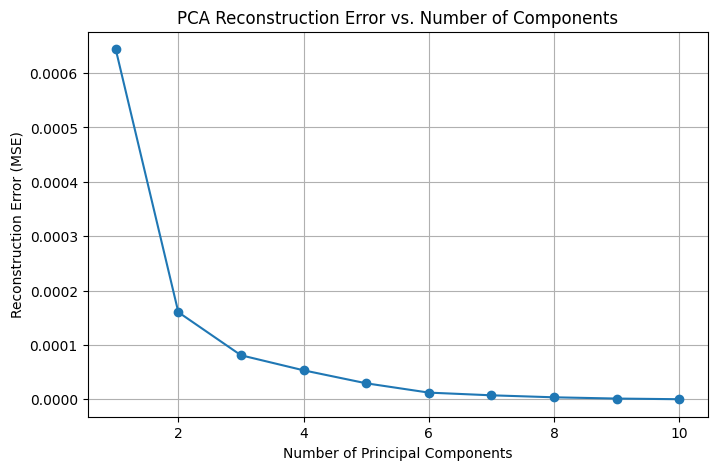

num optimal dimensions: 3


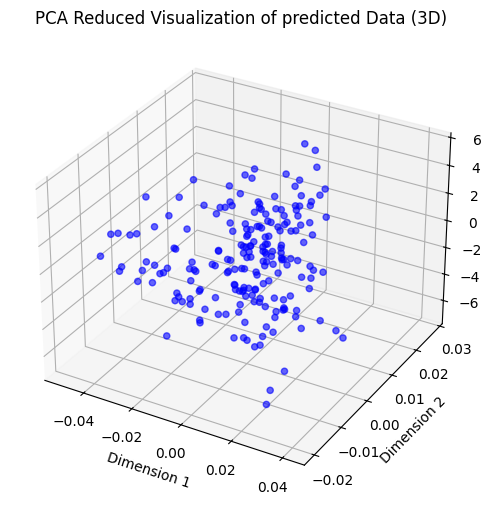

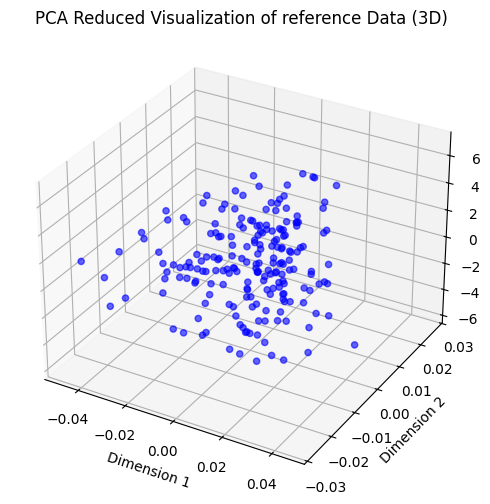

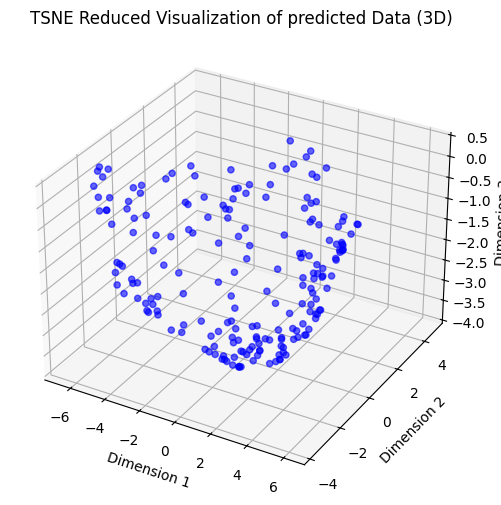

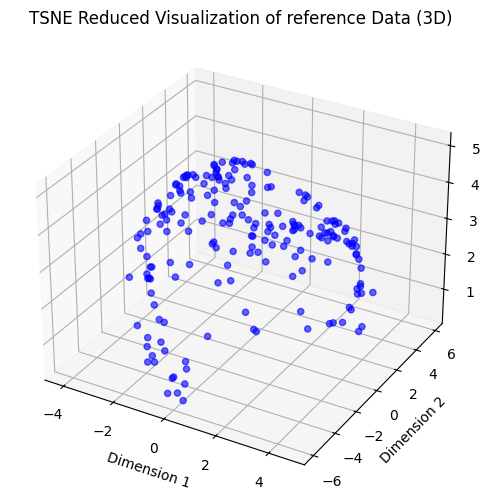

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#train_dataset, val_dataset, test_dataset = dataset
train_loader, val_loader, test_loader = dataset_synthetic(hyperparams)

#CREATE SYNTHETIC DATASET
epochs = 10
lr = 10e-3
hyperparams['embedding_size'] = 10
embedding_size = hyperparams['embedding_size']


# Initialize training 
test_model = model_mlp(hyperparams)
criterion = nn.KLDivLoss(size_average=None, reduce=None, reduction='batchmean', log_target=False)
optimizer = optim.Adam(test_model.parameters(), lr=lr)
best_val_loss = float('inf')


# Print epoch loss
print('Training ...')
progress_bar = tqdm(range(epochs))
for epoch in progress_bar:
    train_loss, train_acc = train_loop(train_loader, test_model, criterion, optimizer, device)
    val_loss, val_acc = val_loop(val_loader, test_model, criterion, device)

    progress_bar.set_postfix(Epoch = f"[{epoch+1}/{epochs}]")
    progress_bar.set_postfix(Train = f"Loss: {train_loss:.4f}, Acc: {train_acc:.4f}" )
    progress_bar.set_postfix(Val = f"Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    
# Final Test Evaluation
test_loss, test_acc, embeddings, predicted_distrib = test_loop(test_loader, test_model, criterion, device)
print("\nFinal Test Results")
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


#PLOT WITH PCA AND TSNE (WHAT DO I PLOT?)
# Number of principal components to test
num_components = np.arange(1, embedding_size + 1)
errors = []

embeddings = torch.cat(embeddings)
# Compute reconstruction error for different numbers of components
for n in num_components:
    pcareduced_distrib, reconstructed_data = apply_pca(embeddings, num_components=n)
    reconstruction_error = np.mean((embeddings.cpu().numpy() - reconstructed_data) ** 2)
    errors.append(reconstruction_error)


# Plot Reconstruction Error vs. Number of Components
plt.figure(figsize=(8, 5))
plt.plot(num_components, errors, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("PCA Reconstruction Error vs. Number of Components")
plt.grid(True)
#plt.savefig(os.path.join(plots_folder_path, 'PCA_analysis.png'))
plt.show()

predicted_distrib = predicted_distrib
real_distrib = torch.cat([batch['label'] for batch in test_loader])
min_index = errors[:3].index(min(errors[:3]))
print('num optimal dimensions:', min_index + 1)
if min_index < 4: #Must be
    num_components = min_index + 1
    pcareduced_pred_distrib, reconstructed_data = apply_pca(predicted_distrib, num_components=num_components)
    tsnereduced_pred_distrib = apply_tsne(predicted_distrib, num_components=num_components)

    pcareduced_distrib, _ = apply_pca(real_distrib, num_components=num_components)
    tsnereduced_distrib = apply_tsne(real_distrib, num_components=num_components)

    #show_distrib(predicted_distrib, predicted=True)
    show_distrib(pcareduced_pred_distrib, method='PCA', predicted=True, show=True)
    show_distrib(pcareduced_distrib, method='PCA', predicted=False, show=True)
    
    show_distrib(tsnereduced_pred_distrib, method='TSNE', predicted=True, show=True)
    show_distrib(tsnereduced_distrib, method='TSNE', predicted=False, show=True)
